
## Load HRET ssh, compute basic statistics about ssh and currents


In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import numpy as np
import xarray as xr

from utils import *

cpd=2.*np.pi/86400. # from cpd to radian/s

#datadir = '/home2/pharos/othr/aponte/tides/HRET/'
datadir = './'

# cartopy
crs = ccrs.PlateCarree()

In [2]:
# load hret for one constituent
hret = xr.open_dataset(datadir+'Carrere_HRET_testing.nc',chunks={'longitude': 500, 'latitude': 500})
#hret = hret.sel(longitude=slice(140.,270.),latitude=slice(-40.,40.))
print(hret)

# consituents
constituents = ['M2','N2','S2','K1','O1','P1']
omega = {'M2': 2.,'N2': 2.,'S2': 2.,'K1': 1.,'O1': 1.,'P1': 1.} # cpd, approximate should load true one from library

<xarray.Dataset>
Dimensions:    (latitude: 2640, longitude: 7200)
Coordinates:
  * longitude  (longitude) float64 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 ...
  * latitude   (latitude) float64 -66.0 -65.95 -65.9 -65.85 -65.8 -65.75 ...
Data variables:
    M2re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    M2im       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    K1re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    K1im       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    S2re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    S2im       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    O1re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    O1im       (latitude, longitude) float64 dask.array<shape=(

/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


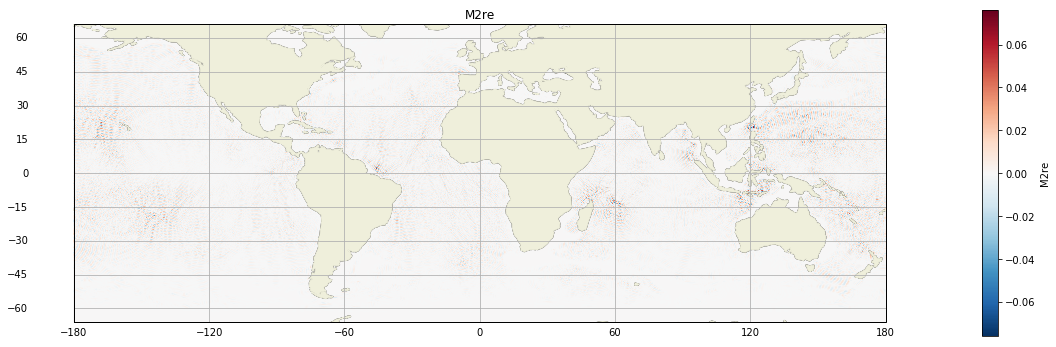

In [3]:
cst='M2'

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111, projection=crs)
#
hret[cst+'re'].plot()
ax.set_title(cst+'re')
gl = ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
plt.show()


In [4]:
# plot longitudinal mean of amplitudes
Am = dict()
Astd = dict()
for cst in constituents:
    Am[cst] = np.sqrt(hret[cst+'re']**2+hret[cst+'im']**2).mean('longitude')
    Astd[cst] = np.sqrt(hret[cst+'re']**2+hret[cst+'im']**2).std('longitude')    

Text(0.5,0,'[cm]')

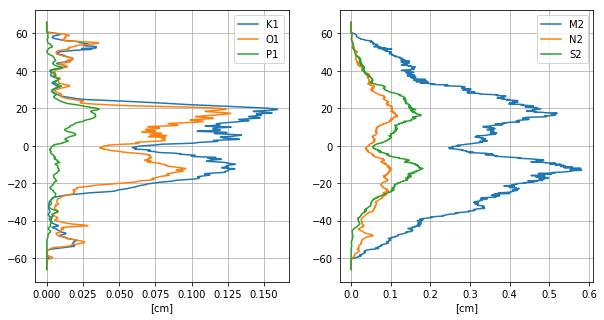

In [5]:
fig=plt.figure(figsize=(10,5))

lat=Am['M2']['latitude'].values

# diurnal constituents
ax = fig.add_subplot(121)
for cst in constituents:
    if omega[cst]<1.5:
        ax.plot(Am[cst]*1.e2,lat,label=cst)
ax.grid()
ax.legend()
ax.set_xlabel('[cm]')

# semidiurnal constituents
ax = fig.add_subplot(122)
for cst in constituents:
    if omega[cst]>1.5:
        ax.plot(Am[cst]*1.e2,lat,label=cst)
ax.grid()
ax.legend()
ax.set_xlabel('[cm]')


---

## start looking at velocities

\begin{aligned}
\partial_t u - fv &= -g\partial_x \eta, \\
\partial_t v + fu &= -g\partial_y \eta. 
\end{aligned}


Assuming $u=\Re ( u_c e^{-i\omega t})$ where $u_c = u_r + i u_i$

\begin{aligned}
-i\omega u_c - f v_c &= -g\partial_x \eta_c, \\
-i\omega v_c + f u_c &= -g\partial_y \eta_c.
\end{aligned}


(Need to check signs)

Which leads to:

\begin{aligned}
u_c = -g \frac{i\omega\partial_x \eta_c -f \partial_y \eta_c}{\omega^2 - f^2}, \\
v_c = -g \frac{f\partial_x \eta_c + i \omega \partial_y \eta_c}{\omega^2 - f^2}.
\end{aligned}



In [6]:
# compute Coriolis frequency
f = 2*2*np.pi/86400.*np.sin(np.pi/180.*hret['latitude'])

#
cst = 'M2'
detadx_c, detady_c = grad(ri2c(hret[cst+'re'],hret[cst+'im']), mask=hret['mask'])
u_c, v_c = mom_inv(detadx_c, detady_c, f, omega[cst]*cpd)


/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


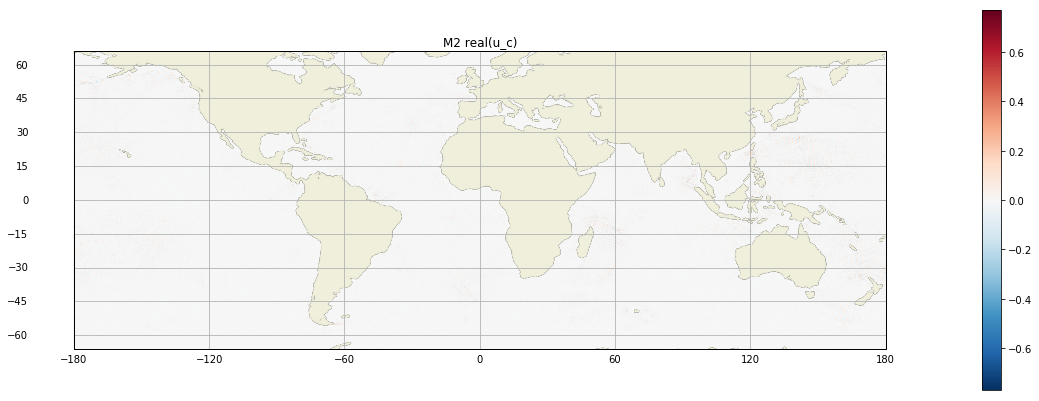

In [7]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=crs)
#
toplt = np.real(u_c)
toplt = toplt.where(np.abs(toplt)<1.) # mask values larger than 1 m/s
toplt.plot()
ax.set_title(cst+' real(u_c)')
gl=ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
plt.show()


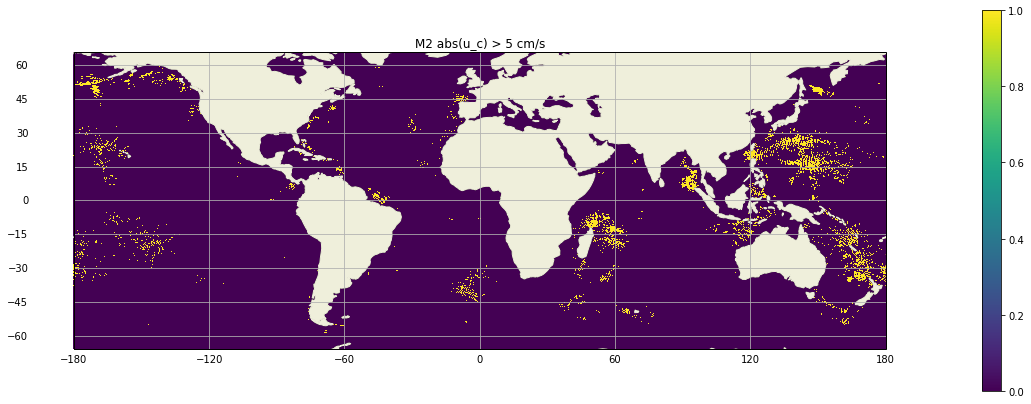

In [8]:
# map values above >10cm/s
toplt = np.abs(u_c)
threshold=.05
toplt = toplt.where(toplt<threshold,other=1.)
toplt = toplt.where(toplt>=threshold,other=0.)

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=crs)
#
toplt.plot(vmin=0.,vmax=1.)
ax.set_title(cst+' abs(u_c) > %d cm/s'%(threshold*1.e2))
gl=ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
plt.show()



In [9]:
# plot longitudinal mean of amplitudes
Um = dict()
Vm = dict()
for cst in constituents:
    detadx_c, detady_c = grad(ri2c(hret[cst+'re'], hret[cst+'im']), mask=hret['mask'])
    u_c, v_c = mom_inv(detadx_c, detady_c, f, omega[cst]*cpd)
    Um[cst] = np.abs(u_c).mean('longitude')
    Vm[cst] = np.abs(v_c).mean('longitude')    

<xarray.DataArray (latitude: 2639)>
array([1.532681e-17, 1.426398e-17, 1.319624e-17, ..., 1.203435e-17,
       1.205868e-17, 1.225989e-17])
Coordinates:
  * latitude  (latitude) float64 -66.0 -65.95 -65.9 -65.85 -65.8 -65.75 ...
<xarray.DataArray (latitude: 2639)>
array([4.342717e-18, 3.958860e-18, 3.910773e-18, ..., 9.563918e-18,
       9.388784e-18, 8.778579e-18])
Coordinates:
  * latitude  (latitude) float64 -66.0 -65.95 -65.9 -65.85 -65.8 -65.75 ...
<xarray.DataArray (latitude: 2639)>
array([9.338930e-18, 8.580426e-18, 7.947447e-18, ..., 5.594207e-18,
       5.655946e-18, 5.764944e-18])
Coordinates:
  * latitude  (latitude) float64 -66.0 -65.95 -65.9 -65.85 -65.8 -65.75 ...


/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


Text(0.5,0,'[cm/s]')

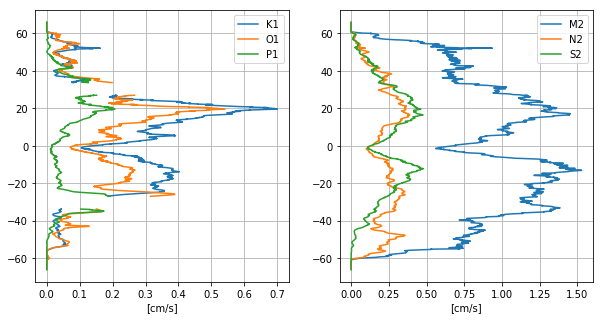

In [10]:
fig=plt.figure(figsize=(10,5))

lat=Um['M2']['latitude'].values

# diurnal constituents
ax = fig.add_subplot(121)
for cst in constituents:
    if omega[cst]<1.5:
        toplt = Um[cst].where(np.abs((omega[cst]*cpd-f)/f)>.1)
        toplt = toplt.where(np.abs((omega[cst]*cpd+f)/f)>.1)
        print(toplt)
        ax.plot(toplt*1.e2,lat,label=cst)
ax.grid()
ax.legend()
ax.set_xlabel('[cm/s]')

# semidiurnal constituents
ax = fig.add_subplot(122)
for cst in constituents:
    if omega[cst]>1.5:
        ax.plot(Um[cst]*1.e2,lat,label=cst)
ax.grid()
ax.legend()
ax.set_xlabel('[cm/s]')
